

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>




## Interactive Demo of Model Complexity & Model Variance

#### Developed by: Stephanie Molitor
#### Walker Department of Mechanical Engineering, The University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

This demo will highlight the relationship between model complexity and model variance as part of the model bias-variance tradeoff. This GUI will fit a dataset using polynomial regression, and model complexity can be modulated by changing the order of the polynomial used to fit the training data, whereby a higher order polynomial results in a more complex model. 

This GUI allows the user to select five levels of model complexity (i.e., polynomial order), then bootstraps the dataset to create multiple realizations of the training data, each of which is used to generate a polynomial regression model. The models are all plotted in order to visualize how the complexity of the model changes the goodness of fit to the training data, as well as how moxel complexity affects the variation between models created from different subsets of training data. 

Finally, scatter plots of the averange and spread of the mean squared error over the training data are generated to visualize how model variance changes with increased model complexity.


### Import Packages


In [1]:
import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root

import pandas as pd                                         # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib; import matplotlib.pyplot as plt        # plotting
from subprocess import check_call
from sklearn.model_selection import train_test_split        # train and test split
import warnings
warnings.filterwarnings('ignore')                           # supress warnings

%matplotlib inline
import sys                                              # supress output to screen for interactive variogram modeling
import io
from sklearn.metrics import mean_squared_error          # model error calculation
import scipy                                            # kernel density estimator for PDF plot
from ipywidgets import interactive      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox

from sklearn.linear_model import LinearRegression           # linear regression with scikit learn
from sklearn.preprocessing import PolynomialFeatures        # polynomial basis expansion
from scipy import stats                                     # statistical summary from a 2D ndarray
import seaborn as sns                                       # multivariate statistical displays


### Load Data

The following workflow applies the .csv file '31D_Porosity.csv'. The dataset is publically available on Proferssor Michael Pyrcz's GitHub [here](https://github.com/GeostatsGuy/GeoDataSets)  

We will work with the following features:

* **normal score porosity** - fraction of rock void 
* **depth** - in units of meters



In [2]:
df2 = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/1D_Porosity.csv") # load the data from Dr. Pyrcz's github repository
df2.head()                                              # we could also use this command for a table preview 

,Depth,Nporosity
0,0.25,-1.37
1,0.50,-2.08
2,0.75,-1.67
3,1.00,-1.16
4,1.25,-0.24


### Min/Max Normalize Predictor Features

Normalize our predictor features to be over a range of [-1, 1].

In [3]:
depth_min = df2['Depth'].values.min(); depth_max = df2['Depth'].values.max()
Npor_min = df2['Nporosity'].values.min(); Npor_max = df2['Nporosity'].values.max()
df2['norm_Depth'] = (df2['Depth'] - depth_min)/(depth_max - depth_min) * 2 - 1
df2['norm_Nporosity'] = (df2['Nporosity'] - Npor_min)/(Npor_max - Npor_min) * 2 - 1

df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,40.0,5.125000e+00,2.922613,0.25,2.687500,5.125000e+00,7.562500,10.00
Nporosity,40.0,2.225000e-02,0.992111,-2.08,-0.757500,1.400000e-01,0.742500,2.35
norm_Depth,40.0,-5.551115e-18,0.599510,-1.00,-0.500000,-5.551115e-17,0.500000,1.00
norm_Nporosity,40.0,-5.090293e-02,0.447906,-1.00,-0.402935,2.257336e-03,0.274266,1.00


###  Extract Predictor Features

We want to extract only our min/max normalized predictor features:

* **norm_Nporosity** - fraction of rock void 
* **norm_Depth** - in units of meters

In [4]:
X2 = df2.iloc[:,[0,2]]                        # extract the predictor feature - norm_Nporosity
y2 = df2.iloc[:,[1,3]]                        # extract the response feature - nomr_Depth


### Visualize Complete Normalized Dataset

Generate a scatterplot to visualize our simple 2D dataset.

We will be taking subsets of this dataset to create several instances of (incomplete) training data for model creation.

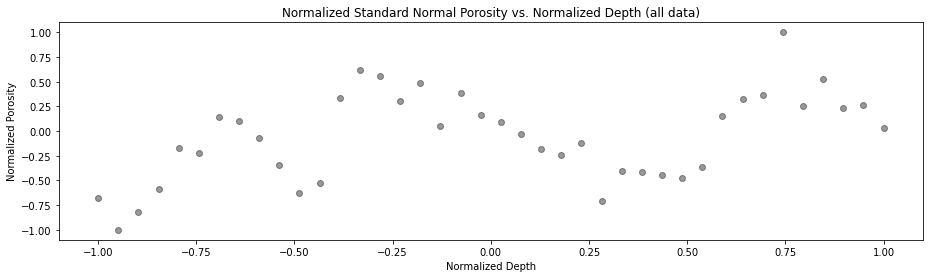

In [5]:
plt.subplot(111)
plt.plot(X2['norm_Depth'].values,y2['norm_Nporosity'].values, 'o', markerfacecolor='black', markeredgecolor='black', alpha=0.4)
plt.title('Normalized Standard Normal Porosity vs. Normalized Depth (all data)')
plt.xlabel('Normalized Depth')
plt.ylabel('Normalized Porosity')

plt.subplots_adjust(left=0.0, right=2.0, wspace=0.2, hspace=0.53)
plt.show()

### Create GUI

The following code:

* makes 5 random subsets of the dataset with 70%/30% train/test split
* loops over 5 polynomial regression fits of each realization of the data, varying polynomial order according to the values chosen by the user
* calculates average MSE and variance of the MSE over the training data
* plots the training data and fit for each model, and the MSE as it varies with model complexity

Pieces of this code are adapted from the "Interactive_Overfit" demo by Michael Pyrcz and John Eric McCarthy II.

In [6]:
#title
str_1 = '         Model Complexity & Model Variance Relationship Demo -------- Prof. Michael Pyrcz and Stephanie Molitor -------- The University of Texas at Austin'
l = widgets.Text(value=str_1, layout=Layout(width='950px', height='45px'))

#brief description of the user inputs
str_2 = '              Manipulate the level of model complexity by changing the order of polynomial that will be used for each of the 5 regression models'
l2 = widgets.Text(value=str_2, layout=Layout(width = '950px', height = '45px'))

#initate sliders to choose polynomical model orders to alter model complexity
n1 = widgets.IntSlider(min=1, max = 50, value=1, step = 1, description = 'Complexity Order Model 1',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)
n2 = widgets.IntSlider(min=1, max = 50, value=3, step = 1, description = 'Complexity Order Model 2',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)
n3 = widgets.IntSlider(min=1, max = 50, value=5, step = 1, description = 'Complexity Order Model 3',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)
n4 = widgets.IntSlider(min=1, max = 50, value=10, step = 1, description = 'Complexity Order Model 4',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)
n5 = widgets.IntSlider(min=1, max = 50, value=40, step = 1, description = 'Complexity Order Model 5',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)

#organize interactive inputs
hbox1 = widgets.HBox([n1,n2, n3])
hbox2 = widgets.HBox([n4, n5])
ui2 = widgets.VBox([l, l2, hbox1, hbox2])


def run_plot(n1, n2, n3, n4, n5):
    
    #bootstrap the data to create multiple sets of (incomplete) training data
    seeds = [73083, 73125, 73090, 1100, 601324]  # random number seeds. 5 seeds to create 5 datasets
    num_orders = [n1, n2, n3, n4, n5]   #polynomical orders selected above - one for each model of the 5 datasets

    #initatiate variables
    cmse_train = np.zeros([len(seeds), len(num_orders)]) # model mean squared error over the training data
    sindex = 1 # seed index
    pltindex = 1; #plotting index
    leading_coeff = np.zeros([len(seeds), len(num_orders)])

    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    
    print('Complete of ' + str(len(seeds)*len(num_orders)) + ': ', end =" ") #progress bar
    for seed in seeds:
        # 70/30% train test split with random seed
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=seed)
        
        oindex = 1 # model order (complexity) index
        for num_order in num_orders:
            polyreg=make_pipeline(PolynomialFeatures(num_order),LinearRegression()) # make the modeling pipeline
            polyreg.fit(X2_train['norm_Depth'].values.reshape(-1, 1), y2_train['norm_Nporosity'].values.reshape(-1, 1))    # fit the model to the data
            
            xy_train_sorted = np.array([np.copy(X2_train['norm_Depth'].values), np.copy(y2_train['norm_Nporosity'].values)]).T #make a deep copy of the input and output values 
            xy_train_sorted = xy_train_sorted[xy_train_sorted[:, 0].argsort()] 
            X2_train_sorted = xy_train_sorted[:, 0]; y2_train_sortedByX2_train = xy_train_sorted[:, 1]  #sort x and correspnsing y values such that x is in ascending order

            ccoefs = np.polyfit(X2_train['norm_Depth'].values,y2_train['norm_Nporosity'].values,num_order)
            y_pred_train = np.polyval(ccoefs, X2_train_sorted)
            cmse_train[(sindex-1, oindex-1)] = mean_squared_error(y2_train['norm_Nporosity'].values, y_pred_train)
            leading_coeff[(sindex-1, oindex-1)] = ccoefs[0]
        
            oindex = oindex+1

            #plot the training data and the predicted model for each complexity & random seed pair
            plt.subplot(len(seeds), len(num_orders), pltindex)
            plt.plot(X2_train['norm_Depth'].values,y2_train['norm_Nporosity'].values, 'o', markerfacecolor='red', markeredgecolor='black', alpha=0.4, label = "Train")
            plt.plot(X2_train_sorted, y_pred_train, color = 'blue')
            plt.title(str(num_order)  + ' order fit (Seed #' + str(sindex) + ')')
            plt.xlabel('Normalized Depth')
            plt.ylabel('Normalized Porosity')

            pltindex = pltindex + 1
            
            print(str(pltindex-1)+ ', ', end =" ")
        sindex = sindex + 1

    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.0, wspace=0.5, hspace=0.5)
    plt.show()

    # calculate model variance via mean squared error across the realizations
    cmse_train_avg = cmse_train.mean(axis=0)
    model_var = cmse_train.var(axis=0)
    
    #plot average of MSE for the different models
    plt.subplot(121)
    plt.plot(num_orders, cmse_train_avg,  'o', markerfacecolor='blue', markeredgecolor='black', alpha=0.4)
    plt.xlabel('Model polynomial order')
    plt.ylabel('Average Training MSE')
    plt.title('Training MSE over Bootstrapped Data')
    
    #plot spread of MSE for the different models
    plt.subplot(122)
    plt.plot(num_orders, model_var, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=0.4)
    plt.xlabel('Model polynomial order')
    plt.ylabel('Variance of Training MSE')
    plt.title('Training MSE over Bootstrapped Data')
    
    plt.subplots_adjust(left=0.0, right=2.0, wspace=0.2, hspace=0.53)
    plt.show()

# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(run_plot, {'n1':n1, 'n2':n2, 'n3':n3, 'n4':n4, 'n5':n5})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating


### Visualize GUI

Create polynomial regression models with different complexity levels (i.e., polynomial order) to investigate how model variance changes with model complexity!


#### The Inputs

* **Complexity Order Model #1-5** - order of polynomial used for each of the 5 polynomial regression models to fit the data. A higher order translates to a more complex model.

#### The Outputs

* **5x5 grid of plots** - For each realization of the bootstrapped data, visualize the data used and model created. Each row indicates a different random subset of the dataset used to train the model. Each column indicates a different complexity of polynomial regression, dictated by you, the user! To visually inspect model variance, see how the models in a given column (i.,e., complexity) vary across the rows (i.e., bootstrapped instances of the data). Models that look the same across the rows have low model variance and models that are very different across rows have high model varaince.
* **Plots of mean squared error (MSE) over the training data** - Average (left) and variance (right) of the errors between the model and training data.




In [7]:
display(ui2, interactive_plot)                           # display the interactive plot

Output(outputs=({'output_type': 'stream', 'text': 'Complete of 25:  1,  2,  ', 'name': 'stdout'},))

### Final Summary

This was a basic demonstration of how model variance increases with model complexity, as the model becomes more overfit to the particular training data.




I hope this was helpful,

*Stephanie Molitor*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
